In [1]:
!pip install transformers torch datasets

In [2]:
!pip install evaluate seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=ae8df758c88853bcc96cf35a0e24639da15f4af3e4d11e8e13655fb4d2624ba6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import time
from transformers import EarlyStoppingCallback
from transformers import TrainerCallback
from transformers import TrainingArguments
from transformers import AutoTokenizer
from sklearn.metrics import classification_report
import numpy as np
import evaluate

In [4]:
def load_data(file_path):
    sentences, labels = [], []
    sentence, label = [], []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() == "":  # Nếu gặp dòng trắng -> kết thúc câu
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                parts = line.strip().split()
                if len(parts) >= 5:  # Đảm bảo có đủ 5 cột
                    token, ner_label = parts[0], parts[3]  # Cột 4 = Label
                    sentence.append(token)
                    label.append(ner_label)
                else:
                    print(f" Dòng lỗi: {line.strip()}")  # Cảnh báo nếu dữ liệu không đúng

    return sentences, labels

metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Lấy nhãn có xác suất cao nhất
    
    # Chuyển đổi nhãn số thành tên nhãn
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    pred_labels = [[id2label[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(predictions, labels)]
    
    results = metric.compute(predictions=pred_labels, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Đọc dữ liệu từ file
train_sentences, train_labels = load_data("/kaggle/input/datatrain/train_data (1).txt")
test_sentences, test_labels = load_data("/kaggle/input/datatrain/test_data (1).txt")

# Kiểm tra kết quả
print(train_sentences[:2])  # In ra 2 câu đầu tiên
print(train_labels[:2])  # In nhãn NER của 2 câu đầu

[['Thành_lập', 'hội_đồng_trường', 'trung_cấp', 'công_lập', '.', 'có', 'yêu_cầu', 'là', 'quyết_định', 'thành_lập', 'hội_đồng_trường', 'trung_cấp', 'công_lập', 'trong', 'đó', 'ghi', 'rõ', 'chức_danh', 'và', 'nhiệm_vụ', 'của', 'các', 'thành_viên', 'trong', 'hội_đồng_trường', '.'], ['Báo_cáo', 'năng_lực', 'cơ_sở', 'kiểm_nghiệm', 'theo', 'mẫu', 'quy_định', 'tại', 'Phụ_lục', '2', 'thông_tư', 'liên_tịch', '20', '.']]
[['O', 'B-CQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CQ', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-VBPL', 'I-VBPL', 'I-VBPL', 'I-VBPL', 'I-VBPL', 'O']]


In [5]:
max_len_train = max(len(sentence) for sentence in train_sentences)
max_len_test = max(len(sentence) for sentence in test_sentences)

# Chọn độ dài lớn nhất làm max_length
max_length = max(max_len_train, max_len_test)

print(f"📏 Độ dài lớn nhất trong tập huấn luyện: {max_len_train}")
print(f"📏 Độ dài lớn nhất trong tập kiểm tra: {max_len_test}")
print(f"✅ Chọn max_length = {max_length}")

📏 Độ dài lớn nhất trong tập huấn luyện: 106
📏 Độ dài lớn nhất trong tập kiểm tra: 62
✅ Chọn max_length = 106


In [6]:
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
# model = AutoModelForTokenClassification.from_pretrained("vinai/phobert-base", num_labels=num_labels)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

def tokenize_and_align_labels(sentences, labels):
    tokenized_inputs = {"input_ids": [], "attention_mask": [], "labels": []}

    for sentence, label in zip(sentences, labels):
        tokens, label_ids = [], []
        
        for word, lbl in zip(sentence, label):
            word_tokens = tokenizer.tokenize(word)  # Token hóa từng từ
            tokens.extend(word_tokens)
            
            # Gán nhãn cho subword (chỉ nhãn đầu tiên giữ nguyên, phần còn lại là -100)
            label_ids.extend([lbl] + [-100] * (len(word_tokens) - 1))

        # Thêm vào danh sách tokenized
        encoded = tokenizer.encode_plus(tokens, truncation=True, padding="max_length", max_length=200, is_split_into_words=False)
        tokenized_inputs["input_ids"].append(encoded["input_ids"])
        tokenized_inputs["attention_mask"].append(encoded["attention_mask"])
        tokenized_inputs["labels"].append(label_ids + [-100] * (200 - len(label_ids)))  # Đệm -100 để khớp với max_length

    return tokenized_inputs

# Token hóa dữ liệu
train_data = tokenize_and_align_labels(train_sentences, train_labels)
test_data = tokenize_and_align_labels(test_sentences, test_labels)



config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [8]:
print("Input IDs sample:", train_data["input_ids"][:2])
print("Attention mask sample:", train_data["attention_mask"][:2])
print("Labels sample:", train_data["labels"][:2])
print("Label types:", type(train_data["labels"][0][0]))  # Kiểm tra kiểu dữ liệu


Input IDs sample: [[0, 13193, 20901, 17806, 56310, 6657, 3718, 5, 10, 285, 8, 261, 763, 20901, 17806, 56310, 6657, 3718, 12, 37, 701, 297, 4202, 6, 527, 7, 9, 496, 12, 20901, 17806, 56310, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 2699, 1158, 341, 8721, 63, 585, 209, 35, 22635, 76, 7641, 15552, 431, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [9]:
# Danh sách nhãn duy nhất trong tập dữ liệu
unique_labels = ["O", "B-CQ", "I-CQ", "B-ĐT", "I-ĐT", "B-NG", "I-NG"]

# Tạo ánh xạ từ nhãn sang số
label2id = {label: idx for idx, label in enumerate(unique_labels)}
label2id["PAD"] = -100  # Nhãn padding giữ nguyên là -100

# Tạo ánh xạ ngược nếu cần convert lại sau huấn luyện
id2label = {idx: label for label, idx in label2id.items()}

print(label2id)  # Kiểm tra ánh xạ


{'O': 0, 'B-CQ': 1, 'I-CQ': 2, 'B-ĐT': 3, 'I-ĐT': 4, 'B-NG': 5, 'I-NG': 6, 'PAD': -100}


In [10]:
train_data["labels"] = [
    [label2id[label] if label in label2id else -100 for label in labels]
    for labels in train_data["labels"]
]

test_data["labels"] = [
    [label2id[label] if label in label2id else -100 for label in labels]
    for labels in test_data["labels"]
]


In [11]:
# Chuyển dữ liệu thành Dataset
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

# Chuyển sang tensor để dùng với PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [12]:
# Load model PhoBERT cho NER (với số lớp bằng số nhãn)
num_labels = len(label2id) - 1  # Trừ "PAD"
print(f"✅ Số nhãn: {num_labels}")

model = AutoModelForTokenClassification.from_pretrained("vinai/phobert-base", num_labels=num_labels)

model.config.hidden_dropout_prob = 0.3  # Mặc định thường là 0.1
model.config.attention_probs_dropout_prob = 0.3  # Mặc định thường là 0.1

✅ Số nhãn: 7


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Đánh giá sau mỗi X bước
    save_strategy="epoch",
    learning_rate=3e-5,
    save_steps=300,  # Lưu checkpoint mỗi 500 bước
    logging_dir="./logs",
    logging_steps=50,  # Hiển thị log sau mỗi 50 bước
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,  # Số epoch
    report_to="none",  # Không gửi log lên WandB
    logging_first_step=True,  # In log ngay từ bước đầu tiên
    load_best_model_at_end=True,  # Tải model tốt nhất khi kết thúc
    weight_decay=0.01,  # Giá trị phổ biến là 0.01 hoặc 0.1
)

print("✅ Training arguments updated!")


✅ Training arguments updated!


In [14]:
from transformers import DataCollatorForTokenClassification

# Sử dụng data collator thay vì truyền tokenizer trực tiếp
data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Dừng sau 3 epoch nếu không cải thiện
)

class TimeCallback(TrainerCallback):
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, args, state, control, **kwargs):
        elapsed = time.time() - self.epoch_start_time
        print(f" Epoch {state.epoch:.0f} hoàn thành trong {elapsed:.2f} giây.")

trainer.add_callback(TimeCallback())

trainer.train()
metrics = trainer.evaluate()
print(metrics)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.002600,0.010161,0.989295,0.989782,0.989539,0.998128
2,0.002300,0.017354,0.972129,0.985356,0.978698,0.996912
3,0.001100,0.013140,0.990547,0.990547,0.990547,0.998284


 Epoch 1 hoàn thành trong 2338.29 giây.
 Epoch 2 hoàn thành trong 2347.02 giây.
 Epoch 3 hoàn thành trong 2344.71 giây.


{'eval_loss': 0.010160745121538639, 'eval_precision': 0.9892954669579465, 'eval_recall': 0.9897819791268236, 'eval_f1': 0.9895386632432874, 'eval_accuracy': 0.9981279427350279, 'eval_runtime': 66.839, 'eval_samples_per_second': 149.613, 'eval_steps_per_second': 9.351, 'epoch': 3.0}


In [15]:
# Dự đoán trên tập test
predictions_output = trainer.predict(test_dataset)

# Lấy giá trị dự đoán và nhãn thực tế
predictions = predictions_output.predictions
labels = predictions_output.label_ids

# Chuyển dự đoán từ logits sang nhãn (chọn chỉ số có xác suất cao nhất)
predictions = np.argmax(predictions, axis=2)

# Chuẩn bị danh sách y_true và y_pred đúng cách
y_true, y_pred = [], []

for label_seq, pred_seq in zip(labels, predictions):
    for true_label, pred_label in zip(label_seq, pred_seq):
        if true_label != -100:  # Bỏ qua giá trị padding
            y_true.append(id2label[true_label])
            y_pred.append(id2label[pred_label])

# Kiểm tra độ dài có khớp không
print(f"✅ Số lượng y_true: {len(y_true)}")
print(f"✅ Số lượng y_pred: {len(y_pred)}")

# In classification report
print(classification_report(y_true, y_pred))

✅ Số lượng y_true: 230228
✅ Số lượng y_pred: 230228
              precision    recall  f1-score   support

        B-CQ       1.00      1.00      1.00      7105
        B-NG       1.00      1.00      1.00      4087
        B-ĐT       1.00      0.99      0.99      7109
        I-CQ       0.96      1.00      0.98      2402
        I-NG       1.00      1.00      1.00      4087
        I-ĐT       0.99      0.97      0.98      6031
           O       1.00      1.00      1.00    199407

    accuracy                           1.00    230228
   macro avg       0.99      0.99      0.99    230228
weighted avg       1.00      1.00      1.00    230228



In [16]:
train_loss = []
eval_loss = []
train_f1 = []
eval_f1 = []
epochs = []
steps = []  # Lưu số bước để vẽ train_loss

for log in trainer.state.log_history:
    if "loss" in log:  # Train loss được ghi sau mỗi logging_steps
        train_loss.append(log["loss"])
        steps.append(log["step"])  # Lưu số bước để vẽ train_loss
    if "epoch" in log and "eval_loss" in log:  # Chỉ lấy epoch nếu có eval_loss
        epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
    if "eval_f1" in log:
        eval_f1.append(log["eval_f1"])

# Đảm bảo số epochs và eval_loss khớp nhau
epochs = epochs[:len(eval_loss)]

print(f"Số lượng epochs: {len(epochs)}")
print(f"Số lượng train_loss: {len(train_loss)}")
print(f"Số lượng eval_loss: {len(eval_loss)}")
print(f"Số lượng train_f1: {len(train_f1)}")
print(f"Số lượng eval_f1: {len(eval_f1)}")

Số lượng epochs: 4
Số lượng train_loss: 418
Số lượng eval_loss: 4
Số lượng train_f1: 0
Số lượng eval_f1: 4


In [17]:
import matplotlib.pyplot as plt

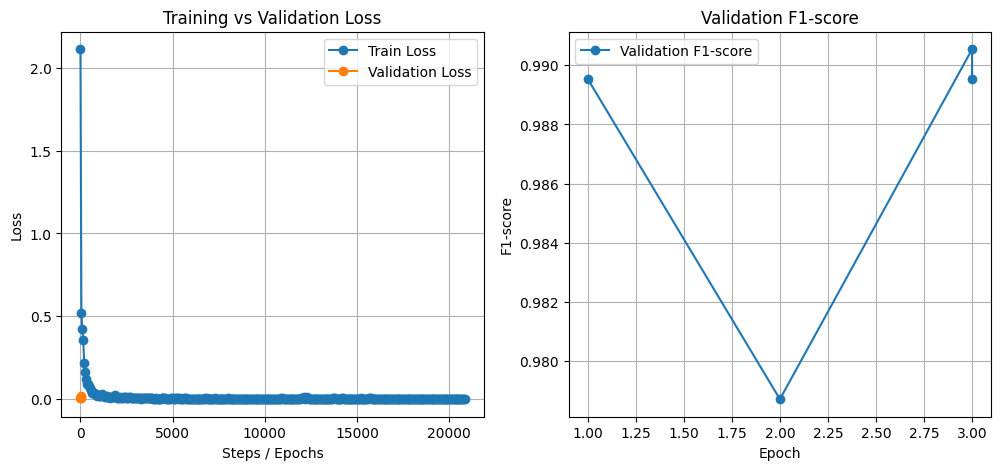

In [18]:
plt.figure(figsize=(12, 5))

# Vẽ Train Loss theo Steps
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Train Loss", marker="o")  # Dùng steps thay vì epochs
plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")  # Vẫn dùng epochs cho eval_loss
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.grid()

# Vẽ F1-score (chỉ có mỗi epoch)
plt.subplot(1, 2, 2)
plt.plot(epochs[:len(eval_f1)], eval_f1, label="Validation F1-score", marker="o")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("Validation F1-score")
plt.legend()
plt.grid()

plt.show()

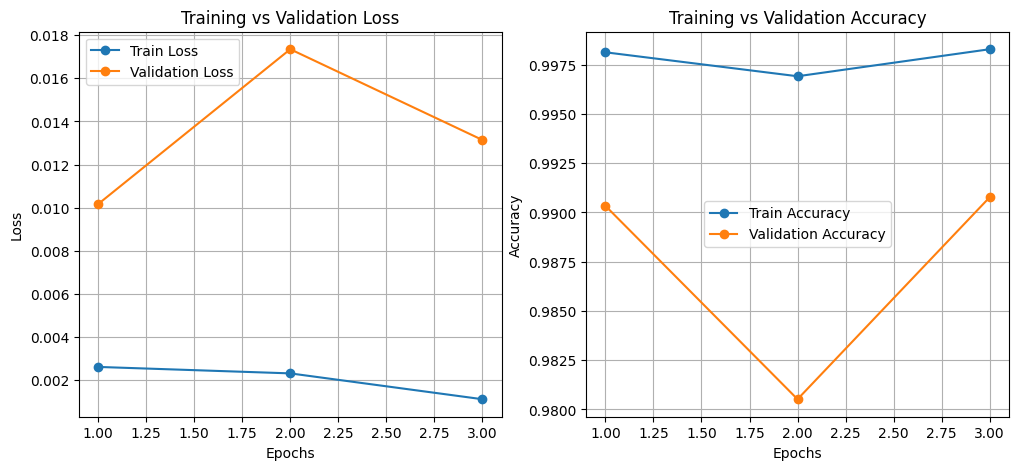

In [23]:
epochs = [1, 2, 3]
train_loss = [0.002600, 0.002300, 0.001100]
val_loss = [0.010161, 0.017354, 0.013140]
train_accuracy = [0.998128, 0.996912, 0.998284]
val_accuracy = [0.990336, 0.980519, 0.990771]

# Vẽ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracy, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()

plt.show()